In [ ]:
# Main Code Repository

In [18]:
import numpy as np
import time
import os


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import torchvision.models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

In [21]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

CUDA is not available.  Training on CPU ...


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# folder_path = '###'
# files = os.listdir(folder_path)


# Load data from Kaggle
{"username":"remcdl","key":"7499823d00bfc21b2c57c385ad1bfa45"}

!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"remcdl","key":"7499823d00bfc21b2c57c385ad1bfa45"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ananthu017/emotion-detection-fer
!unzip /content/emotion-detection-fer.zip -d kaggle_data

Streaming output truncated to the last 5000 lines.
  inflating: kaggle_data/train/sad/im37.png  
  inflating: kaggle_data/train/sad/im370.png  
  inflating: kaggle_data/train/sad/im3700.png  
  inflating: kaggle_data/train/sad/im3701.png  
  inflating: kaggle_data/train/sad/im3702.png  
  inflating: kaggle_data/train/sad/im3703.png  
  inflating: kaggle_data/train/sad/im3704.png  
  inflating: kaggle_data/train/sad/im3705.png  
  inflating: kaggle_data/train/sad/im3706.png  
  inflating: kaggle_data/train/sad/im3707.png  
  inflating: kaggle_data/train/sad/im3708.png  
  inflating: kaggle_data/train/sad/im3709.png  
  inflating: kaggle_data/train/sad/im371.png  
  inflating: kaggle_data/train/sad/im3710.png  
  inflating: kaggle_data/train/sad/im3711.png  
  inflating: kaggle_data/train/sad/im3712.png  
  inflating: kaggle_data/train/sad/im3713.png  
  inflating: kaggle_data/train/sad/im3714.png  
  inflating: kaggle_data/train/sad/im3715.png  
  inflating: kaggle_data/train/sad/im3716

In [3]:
# Define class EmotionDataset

class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        # Map each emotion to indices from 0 ~ 6
        self.classes = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = []
        self.labels = []

        for label in self.classes:
            class_dir = os.path.join(self.root_dir, label)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.images.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        # Map label to index
        label_idx = self.class_to_idx[label]
        return image, label_idx

In [4]:
# Get indicies of the targeted classes

def get_relevant_indices(dataset, classes, target_classes):
    # dataset = [(img1, 0), (img2, 1), (img3, 2), (img4, 0), (img5, 1)]

    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'A'
        if label_class in target_classes:
            indices.append(i)

    # if target class being class0 & class1, then indices = [0, 1, 3, 4]
    return indices

In [5]:
# Load and split data
def get_data_loader(train_directory, test_directory, target_classes, batch_size):
    """ Loads images of facial emotions, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """
    # Letters for classification
    classes = ('angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised')

    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
         [transforms.Grayscale(1),
          transforms.Resize((48, 48)),
         transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))])

    ########################################################################
    # Load Gesture training data using the defined gesture dataset class above
    train_dataset = EmotionDataset(root_dir=train_directory, transform=transform)
    test_dataset = EmotionDataset(root_dir=test_directory, transform=transform)

    # Get the list of indices to sample from
    train_relevant_indices = get_relevant_indices(train_dataset, classes, target_classes)
    test_relevant_indices = get_relevant_indices(test_dataset, classes, target_classes)

    # Split train into 80% train, 20% validation, keep test data
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(train_relevant_indices)

    total_train_size = len(train_relevant_indices)

    train_split = int(total_train_size * 0.8)  # 80% for training
    val_split = int(total_train_size * 0.2)    # 20% for validation

    # split into training and validation indices
    relevant_train_indices = train_relevant_indices[:train_split]
    relevant_val_indices = train_relevant_indices[train_split:train_split + val_split]

    relevant_test_indices = test_relevant_indices

    ########################################################################
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)

    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             num_workers=1, sampler=val_sampler)

    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)

    return train_loader, val_loader, test_loader, classes

In [6]:
# Load the data in
train_loader, val_loader, test_loader, classes = get_data_loader(
    train_directory = '/content/kaggle_data/train',
    test_directory = '/content/kaggle_data/test',
    target_classes=['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised'],
    batch_size=1) # 1 image per batch

print("Dataset loaded successfully.")

Dataset loaded successfully.


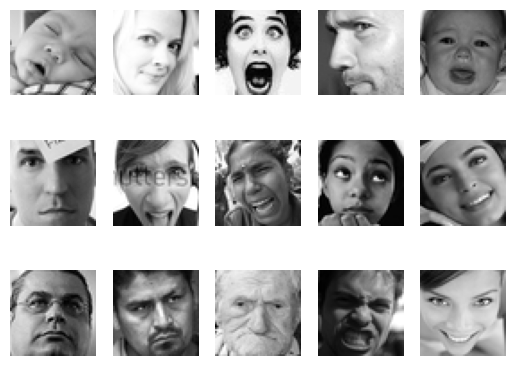

In [7]:
# Sanity check: is the data loaded correctly?

k = 0
for images, labels in train_loader:
    # Only load the 1st image in `images` no matter the batch size
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')

    # only load 15 images
    k += 1
    if k > 14:
        break

In [9]:
torch.cuda.empty_cache()
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [16]:
#Artifical Neural Network Architecture
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6, 10)
        self.fc2 = nn.Linear(10, 7)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
def get_accuracy(model, train=False):
    if train:
        data_loader = train_loader
    else:
        data_loader = val_loader

    correct = 0
    total = 0
    for imgs, labels in data_loader:


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(ALNC(imgs))

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [14]:
def train(model, data, batch_size=20, num_epochs=1):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           #num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

          #### ALNC is alexNet.features (AlexNet without classifier) ####

            out = model(ALNC(imgs))             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole training set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1
            mini_b += 1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train=True))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))


In [17]:
use_cuda = True

model = ANNClassifier()
ALNC = alexNet.features

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model, [], batch_size=1024, num_epochs=20)

CUDA is not available.  Training on CPU ...


RuntimeError: Given groups=1, weight of size [64, 3, 11, 11], expected input[1, 1, 48, 48] to have 3 channels, but got 1 channels instead